# Ajuste de las curvas obtenidas en el transitorio del circuito RCL Sobre amortiguado

En este tutorial analizo los datos adquiridos de un circuito **RLC transitorio sobre amortiguado**.

El circuito tiene las siguientes características:

```
 _____ -V0 (PULSE)+ _____ R _____ L _____ C ____   
|                     |               |         |  
GND                  Vin              VC        GND
```

Parámetros:
- R = 3000 $\Omega$
- L = 100 $m H$
- C = 100 $nF$

- Tiempo característico $\tau = \frac{2 L}{R - \sqrt{ R^2 - 4L/C }} \approx 0.00026$ sec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Tiempo de alto y tiempo de bajo $10\tau$
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa).
- En $V_C$ se mide la tensión en el capacitor respecto de GND (masa).

Empezamos importando las librerías necesarias:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos:

In [8]:
df = pd.read_csv("datos/data_RLC_sobreamortiguado.csv")

df.head()

,time,Vin,VC,I
0,0.000000e+00,-0.004826,-0.002141,1.287229e-06
1,1.428571e-10,0.720997,-0.006174,-3.566663e-07
2,2.857143e-10,1.428574,-0.002501,2.488867e-07
3,4.285714e-10,2.138153,0.000988,1.312949e-07
4,5.714286e-10,2.858414,0.007535,-7.909707e-08


Hacemos un plot exploratorio:

<Axes: xlabel='time'>

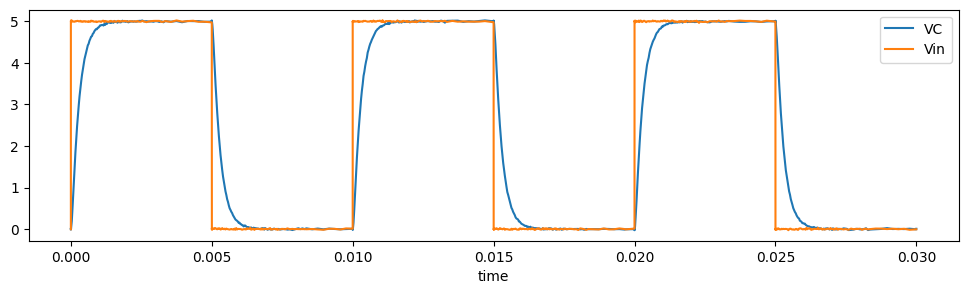

In [9]:
df.plot( x='time', y=['VC','Vin'], figsize=(12,3) )

**Filtramos** los datos para quedarnos solo con uno de transitorios. Nos quedamos con el que esta entre los tiempos 0.010 y 0.015:

<Axes: xlabel='time'>

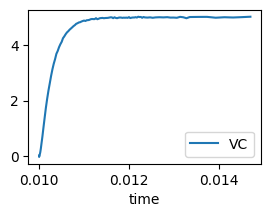

In [10]:
df_alto = df[ (df["time"]<0.015) & (df["time"]>0.010) ]

df_alto.plot(x='time', y='VC', figsize=(3,2))

El eje temporal esta trasladado, **llevamos el origen a cero** restando el primer punto, tambien pasamos nuestros datos a arrays de numpy para trabajar más cómodos el ajuste:

In [11]:
t0 = df_alto["time"].iloc[0]

t = df_alto["time"].to_numpy()-t0

VC = df_alto["VC"].to_numpy()

Definimos una **ecuación** para hacer el ajuste de la tensión que cae en los bornes del capacitor:

$$
V_C = V_0 \big( 1 -  \frac{ s_2 e^{s_1 t} - s_1 e^{s_2 t} }{s_2 - s_1} \big)
$$

In [12]:
def modelo_tension(u, V0, s1, s2):                         
    z= V0*( 1.0 - ( s2*np.exp(s1*u) - s1*np.exp(s2*u) )/( s2-s1 ) )
    return z


Estimamos los valores de los parámeros para pasarselos al algoritmo como **semillas**:

In [13]:
R= 3000
L= 100e-3
C= 100e-9

g = R/(2.0*L)
w02 = 1.0/(L*C)

s1 = -g + np.sqrt( g**2 - w02 )
s2 = -g - np.sqrt( g**2 - w02 )

print (g,w02)
print (s1,s2)

15000.0 100000000.0
-3819.660112501051 -26180.33988749895


**Ajuste**:

In [14]:
# semillas
V0_ini = 5.0
s1_ini  = -4000.0
s2_ini  = -26000.0

popt, pcov = curve_fit(modelo_tension, t, VC, p0=[ V0_ini, s1_ini, s2_ini ] )      

V0, s1, s2 = popt

# Errores estandar
SE_V0, SE_s1, SE_s2 = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f})")
print(f"s1 = ({s1:.4f} ± {SE_s1:.6f})")
print(f"s2 = ({s2:.4f} ± {SE_s2:.6f})")

Parámetros obtenidos del ajuste:
V0 = (4.9992 ± 0.0015)
s1 = (-3835.6166 ± 12.417564)
s2 = (-25560.5313 ± 378.422683)


Hacemos un **plot** con los datos del experimento y el ajuste:

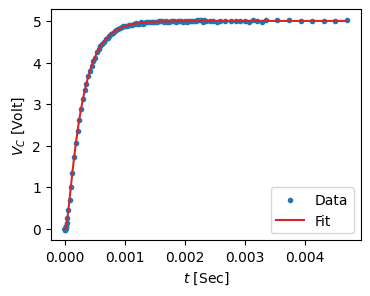

In [15]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                                    # datos

ax.plot( t, modelo_tension(t, V0, s1, s2), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$V_C$ [Volt]")

plt.legend(loc=4)
plt.show()